# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
	* [1.1 Problem statement](#1.1-Problem-statement)
* [2. Training part-of-speech tagger](#2.-Training-part-of-speech-tagger)
	* [2.1 Dataset](#2.1-Dataset)
	* [2.2 Attributes and features extraction](#2.2-Attributes-and-features-extraction)
	* [2.3 Models and optimization options](#2.3-Models-and-optimization-options)
* [3. Trained model evaluation](#3.-Trained-model-evaluation)
* [4. Using a trained part-of-speech tagger](#4.-Using-a-trained-part-of-speech-tagger)
	* [4.1 Decoding method](#4.1-Decoding-method)
	* [4.2 Decoding performance](#4.2-Decoding-performance)
* [5. Literature](#5.-Literature)


In [1]:
# first we define relevant directories
import sys
# in case PySeqLab package is not installed, 
# we can download the package repository from https://bitbucket.org/A_2/pyseqlab
# and then we add the location of the repository to the python system path
# location of the PySeqLab repository on disk -- INSERT location or discard if PySeqLab package is already installed
pyseqlab_package_dir = ""
sys.path.insert(0, pyseqlab_package_dir)
import os
# project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory of the project
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
tutorials_dir = os.path.join(project_dir, 'tutorials')
# to use for customizing the display/format of the cells
from IPython.core.display import HTML
with open(os.path.join(tutorials_dir, 'pseqlab_base.css')) as f:
    css = "".join(f.readlines())
HTML(css)


# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> the process/workflow for building part-of-speech tagger (i.e. based on CRFs model formalism)</li>
<li> training the built model and evaluating its performance</li>
<li> reviving the trained model and decoding new sequences (i.e. test sequences that were not used for training)</li>
</ul>

## 1.1 Problem statement

<blockquote>Given a set of sentences where each sentence is composed of words, the goal is to predict the part-of-speech label of every word in the sentence.</blockquote>

The goal of the <a href="http://www.geniaproject.org/genia-corpus/pos-annotation">GENIA POS annotation task</a> is to build part-of-speech taggers using medical-related texts/corpus.

<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need to clone the <a href="https://bitbucket.org/A_2/part-of-speech-tagger">part-of-speech tagger repository from bitbucket</a> to our disk locally. Then, navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder. 

<strong><span style="color:red;">NB: </span></strong> <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> should be already installed or included in the python system path before we proceed.

# 2. Training part-of-speech tagger

The <code class="pseq_code">src</code> directory in the cloned repository includes the following main modules: 
<ul>
<li><code class="pseq_code">genia_xml_parser.py</code></li>
<li><code class="pseq_code">pos_attr_extractor.py </code></li>
<li><code class="pseq_code">train_tagger_workflow.py </code></li>
</ul>
 
As a prerequisite, refer to <a href="http://pyseqlab.readthedocs.io/en/latest/methods_tutorials.html">these tutorials</a> describing in detail the model building and training process using  <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> package.


## 2.1 Dataset

To build our training dataset, we processed the raw files using <code class="pseq_code">genia_xml_parser.py module</code>. This process generated our final training dataset (<code class="pseq_code">GENIA_dataset_v1.txt</code>). The tree path for the dataset directory should look like this:
<pre style="font-size:0.9em">
├── dataset
│   ├── GENIA_POS
│   │   ├── GENIAcorpus3.02.pos.txt
│   │   ├── GENIAcorpus3.02.merged.xml
│   │   ├── LICENSE
│   │   ├── GENIA_dataset_v1.txt
│   │   ├── genia_pos_xml_structure
│   │   ├── GENIAcorpus3.02.pos.xml
│   │   ├── gpml.merged.dtd
</pre>

In our current setting, we will randomly split our dataset (i.e. <code class="pseq_code">GENIA_dataset_v1.txt</code>) into 90% for training and 10% for testing similar to the approach reported in (Tsuruoka et al., 2005).

## 2.2 Attributes and features extraction

We start by defining our attribute extractor that will be used to generate attributes from the parsed sequences. Our attribute extractor <code class="pseq_class"> POS_AttributeExtractor</code> is subclass of <code class="pseq_class">GenericAttributeExtractor</code> class implemented in <code class="pseq_code">pos_attr_extractor.py</code> module. It defines attributes based on the <code class="pseq_code">words</code> track in addition to new computed attributes that measure/capture  <code class="pseq_code">orthographic, shape and prefix/suffix</code> attributes at each position in the sequence. Below is <a href="#pos_attrext_demo">an example</a> of the attributes extracted using our <code class="pseq_class">POS_AttributeExtractor</code> class from a sequence in our training file. 

After defining our attribute extractor, we define the feature templates that are used by the feature extractors to generate features. Feature templates and feature extraction are described in detail in <a href="http://pyseqlab.readthedocs.io/en/latest/_static/templates_and_features_extraction.html">this tutorial</a>.

In the <code class="pseq_code">train_tagger_workflow.py</code> module, we define our feature templates using <code class="pseq_function">template_config()</code> function.

<pre style="font-size:0.75em">
def template_config():
    template_generator = TemplateGenerator()
    template_XY = {}
    # generating template for attr_name = w
    template_generator.generate_template_XY('w', 
                                            ('1-gram:2-gram:3-gram', range(-2,3)),
                                            '1-state:2-states:3-states', 
                                            template_XY)
     
    # generating template for the prefix and suffix 
    attr_names = ('prefix', 'suffix')
    for attr_name in attr_names:
        for i in range(2, 6):
            template_generator.generate_template_XY('{}_{}'.format(attr_name, i),
                                                    ('1-gram', range(0,1)), 
                                                    '1-state', 
                                                    template_XY)
     
    attr_names = ('hasdash', 'hasnum', 'hascap', 'hasallcaps')
    for attr_name in attr_names:
        template_generator.generate_template_XY(attr_name, 
                                                ('1-gram', range(0,1)), 
                                                '1-state', 
                                                template_XY)
 
    attr_names = ('shape', )
    for attr_name in attr_names:
        template_generator.generate_template_XY(attr_name, 
                                                ('1-gram:2-gram:3-gram', range(-1,2)), 
                                                '1-state', 
                                                template_XY)
    template_Y = {'Y':()}
    return(template_XY, template_Y)
</pre>

The defined templates include multiple tracks (i.e. <code class="pseq_code"> w, prefix_2:5, suffix_2:5, hasdash, hasnum, hascap, hasallcaps, and shape</code>) representing the words and the computed attributes based on the words track. The notation <code class="pseq_code">prefix_2:5</code> represents multiple attributes (i.e. newly computed tracks) based on varying prefix lengths such as prefixes of length 2, 3, 4, and 5. <br/>

For the words track (i.e. <code class="pseq_code">w</code>):

<ul><li>We define a window of size 5 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 5 (a window that includes attributes at two previous positions, current position,  and two forward/future positions)</li>
<li>We extract 1 to 3 grams (i.e. <code class="pseq_code">1-gram:2-gram:3-gram</code>) in the specified window </li>
<li>We join these attributes with (1) the current state, (2) the previous and current state, and (3) the two previous states and the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

For the following tracks <code class="pseq_code">{prefix_2:5, suffix_2:5, hasdash, hasnum, hascap, hasallcaps}</code>:

<ul><li>We define a window of size 1 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 1 (a window that includes attribute only at the current position)</li>
<li>We extract unigrams (i.e. <code class="pseq_code">1-gram</code>) in the specified window </li>
<li>We join these attributes with (1) the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

For the <code class="pseq_code">shape</code> track:

<ul><li>We define a window of size 3 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 3 (a window that includes attributes at one previous position, current position and one future position)</li>
<li>We extract unigrams, bigrams and trigrams (i.e. <code class="pseq_code">1-gram:2-gram:3-gram</code>) in the specified window </li>
<li>We join these attributes with (1) the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

## 2.3 Models and optimization options

In the <code class="pseq_code">train_tagger_workflow.py</code> module, we implement the training workflow. In this section, we describe the training setup and the chosen options for performing the training.

We used the following classes:
<ul><li>feature extractor (<code class="pseq_class">HOFeatureExtractor)</code>,</li>
<li>CRFs model (<code class="pseq_class">HOCRFAD</code>) and</li>
<li>CRFs model representation (<code class="pseq_class">HOCRFADModelRepresentation</code>)</li>
</ul>


For the training method (i.e. optimization options), we used the following options:
<ul><li>structured perceptron (<code class="pseq_code">method = COLLINS-PERCEPTRON</code>),</li>
<li>with beam search enabled (<code class="pseq_code">beam_size = 5</code>) and update type equal to max (<code class="pseq_code">update_type = max-fast</code>), </li>
<li>and 10 passes through the training data (<code class="pseq_code">num_epochs = 10</code>)</li>
</ul>

To run the training process, we use <code class="pseq_function">run_training(optimization_options, template_config)</code> function. We pass the optimization options and the function generating the defined feature templates (<a href="#pos_trainmodel">see this code snippet</a>). <a id="pos_trainingprocess"></a>The training process will perform the following:
<ol>
<li> read the training file (i.e. <code class="pseq_code">GENIA_dataset_v1.txt</code>) and parse it into sequences</li>
<li> process and dump the parsed sequences on disk in a relevant format for the learning framework </li>
<li> define a data split in which we randomly take 90% of the sequences for training and 10% for testing</li>
<li> build a model based on the processed training sequences (i.e. 90% share) </li>
<li> train the model weights (i.e. estimate the feature weights) using the specified optimization method</li>
<li> use the trained model to decode the training sequences (i.e. 90% share) and write the result to a file</li>
<li> use the trained model to decode the testing sequences (i.e. 10% share) and write the result to a file</li>
<li> return the path to the trained model directory </li>
</ol>

The return value of the training function (i.e. <code class="pseq_code">res</code> -- <a href="#pos_trainmodel">see code snippet below</a>) is a tuple that has the following structure:
<ol>
<li>first entry will be the path to the trained model on disk</li>
<li>second entry will be the performance of the trained model using the training sequences </li>
<li>third entry will be the performance of the trained model using the test sequences</li>
</ol>

During model training, we track the estimated average decoding error by plotting the generated <code class="pseq_code">avg_decodingerror_training</code> file. 

<a id="pos_attrext_demo"></a>

In [2]:
from pos_attr_extractor import *
seq = example()

attr_desc {'suffix_2': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pos_attr_extractor.POS_AttributeExtractor object at 0x7fc4482d56a0>>, 'encoding': 'categorical', 'description': 'suffix of length 2 for the word observation'}, 'prefix_3': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pos_attr_extractor.POS_AttributeExtractor object at 0x7fc4482d56a0>>, 'encoding': 'categorical', 'description': 'prefix of length 3 for the word observation'}, 'hascap': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pos_attr_extractor.POS_AttributeExtractor object at 0x7fc4482d56a0>>, 'encoding': 'categorical', 'description': 'Orthographic feature -- hascap'}, 'suffix_3': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pos_attr_extractor.POS_AttributeExtractor object at 0x7fc4482d56a0>>, 'encoding': 'categorical', 'description': 'suffix of length 3 

<a id="pos_trainmodel"></a>

1 sequences have been processed
2 sequences have been processed
3 sequences have been processed
4 sequences have been processed
5 sequences have been processed
6 sequences have been processed
7 sequences have been processed
8 sequences have been processed
9 sequences have been processed
10 sequences have been processed
11 sequences have been processed
12 sequences have been processed
13 sequences have been processed
14 sequences have been processed
15 sequences have been processed
16 sequences have been processed
17 sequences have been processed
18 sequences have been processed
19 sequences have been processed
20 sequences have been processed
21 sequences have been processed
22 sequences have been processed
23 sequences have been processed
24 sequences have been processed
25 sequences have been processed
26 sequences have been processed
27 sequences have been processed
28 sequences have been processed
29 sequences have been processed
30 sequences have been processed
31 sequences have b

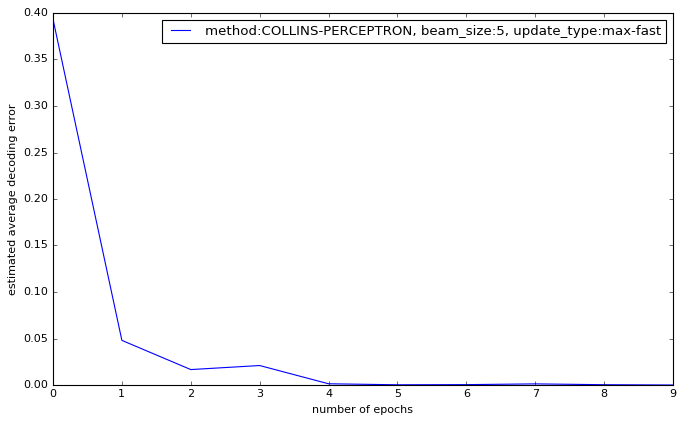

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
from pyseqlab.utilities import ReaderWriter
# import the module containing training workflow
# we use only 100 sequences for demonstration
# to go through the whole file simply omit passing the num_seqs keyword argument
num_seqs = 100
from train_tagger_workflow import *
optimization_options = {"method" : "COLLINS-PERCEPTRON",
                        "num_epochs":10,
                        'update_type':'max-fast',
                        'beam_size':5,
                        'shuffle_seq':True,
                        "tolerance":1e-6
                        }



# demonstrate training using only 100 sequences from the both the training and test file
res = run_training(optimization_options, template_config, num_seqs=num_seqs)
model_dir = res[0]

# using all sequences from the both the training and test file
# res = run_training(optimization_options, template_config)
# evaluating the performance of the models
# models_dir = res[0]

def plot_avg_decodingerror(model_dir):
    # plot the estimated average decoding error during training phase
    avg_decerror = ReaderWriter.read_data(os.path.join(model_dir, 'avg_decodingerror_training'))
    plt.plot(avg_decerror[1:], label="method:{}, beam_size:{}, update_type:{}".format(optimization_options['method'], 
                                                                                      optimization_options['beam_size'],
                                                                                      optimization_options['update_type']))
    plt.legend(loc='upper right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated average decoding error')
    
plot_avg_decodingerror(model_dir)

# 3. Trained model evaluation

As part of the training workflow we defined earlier (<a href="#pos_trainingprocess">see here</a>), once the model training ended, we used the trained model to decode the training (90% share) and test (10% share) sequences in addition to reporting performance evaluation. The performance evaluation is demonstrated again in (<a href="#pos_perfeval">this code snippet</a>). To verify the performance evaluation computation, we will use the <code class="pseq_code">conlleval.pl</code> script to compare both results (<a href="#pos_perfevalscript">see this code section</a>).

As a reminder, a trained model folder will have the following structure:

<pre style="font-size:0.8em;">
├── avg_decodingerror_training
├── crf_training_log.txt
├── decoding_seqs
│   ├── test_fold_0.txt
│   ├── train_fold_0.txt
├── model_parts
│   ├── class_desc.txt
│   ├── FE_templateX
│   ├── FE_templateY
│   ├── MR_L
│   ├── MR_modelfeatures
│   ├── MR_modelfeaturescodebook
│   ├── MR_Ycodebook
│   ├── weights
</pre>

Each model has a <code class="pseq_code">model_parts</code> folder. The decoded sequences (i.e. decoded training and test files) are found under <code class="pseq_code">decoding_seqs</code> folder.

<a id="pos_perfeval"></a>

In [4]:
# model_dir is the path to the trained model (i.e. the model we just trained earlier)
crf_percep = revive_learnedmodel(model_dir)
data_type = ('training', 'test')
for i in range(1,3):
    taglevel_perf = res[i]['taglevel_confusion_matrix']
    print("evaluating the performance on {} data".format(data_type[i-1]))
    print("f1:", res[i]['f1'])
    for state, code in crf_percep.model.Y_codebook.items():
        print("confusion_matrix for state={}: ".format(state))
        print(taglevel_perf[code])
        print("-"*40)
    print()
    

evaluating the performance on training data
f1: 0.997297297297
confusion_matrix for state=VB: 
[[   29.     0.]
 [    0.  2191.]]
----------------------------------------
confusion_matrix for state=NNS: 
[[  1.48000000e+02   0.00000000e+00]
 [  1.00000000e+00   2.07100000e+03]]
----------------------------------------
confusion_matrix for state=,: 
[[   76.     0.]
 [    0.  2144.]]
----------------------------------------
confusion_matrix for state=.: 
[[   90.     0.]
 [    0.  2130.]]
----------------------------------------
confusion_matrix for state=FW: 
[[   10.     0.]
 [    0.  2210.]]
----------------------------------------
confusion_matrix for state=:: 
[[    3.     0.]
 [    0.  2217.]]
----------------------------------------
confusion_matrix for state=CD: 
[[   12.     0.]
 [    0.  2208.]]
----------------------------------------
confusion_matrix for state=IN: 
[[  289.     2.]
 [    0.  1929.]]
----------------------------------------
confusion_matrix for state=VBD: 
[[

<a id="pos_perfevalscript"></a>

In [5]:
# using conlleval.pl script to verify our performance computation
for f in ('train_fold_0.txt', 'test_fold_0.txt'):
    dec_file = os.path.join(model_dir, 'decoding_seqs', f)
    # -r option specifies takes raw input -- no BIO/IOB representation
    # -d option specifies the separator (in our case the file is tab delimited)
    ! ./conlleval.pl -r -d '\t' < $dec_file
    print()

processed 2220 tokens with 2220 phrases; found: 2220 phrases; correct: 2214.
accuracy:  99.73%; precision:  99.73%; recall:  99.73%; FB1:  99.73
                (: precision: 100.00%; recall: 100.00%; FB1: 100.00  17
                ): precision: 100.00%; recall: 100.00%; FB1: 100.00  17
                ,: precision: 100.00%; recall: 100.00%; FB1: 100.00  76
                .: precision: 100.00%; recall: 100.00%; FB1: 100.00  90
                :: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
               CC: precision: 100.00%; recall: 100.00%; FB1: 100.00  78
               CD: precision: 100.00%; recall: 100.00%; FB1: 100.00  12
               DT: precision: 100.00%; recall:  99.43%; FB1:  99.72  175
               EX: precision: 100.00%; recall: 100.00%; FB1: 100.00  2
               FW: precision: 100.00%; recall: 100.00%; FB1: 100.00  10
               IN: precision:  99.31%; recall: 100.00%; FB1:  99.66  291
               JJ: precision:  99.51%; recall:  99.51%; FB1:  9

# 4. Using a trained part-of-speech tagger

<strong><span style="color:red">NB</span></strong>: Before proceeding, we have to unzip the <code class="pseq_code">trained_models</code> directory so that we can explore and assess the trained model.

In this section, we demonstrate how to revive a trained model for part-of-speech tagging and use it to decode a file comprising new/unseen sequences (i.e. test sequences).

As a reminder, the trained models (including their components) are found under <code class="pseq_code">trained_models </code>folder in the cloned repository. We have to unzip them first before proceeding.

To use/revive a trained model dumped on disk, we use <code class="pseq_function">revive_learnedmodel(args)</code> function. It takes the path to the trained models' directory.

In [7]:
# we get the trained model parts directory -- check the tree path in the cell above
trained_model_dir = os.path.join(project_dir, 'trained_models', '2017_1_8-0_9_48_894305')
# loading the trained model
crf_m = revive_learnedmodel(trained_model_dir)

After we revive our model, we will use a test dataset that we did not use for model building or training. The test file is found under <code class="pseq_code">eval_model</code> folder. The tree path of the directory:

<pre style="font-size:0.9em">
├── 2017_1_8-0_9_48_894305
│   ├── eval_model
│   │   ├── test.txt
│   │   ├── train.txt
│   │   ├── dec_testseqs_fold_0_eval.txt
│   │   ├── dec_trainseqs_fold_0_eval.txt
</pre>

The test file in <code class="pseq_code">eval_model</code> folder is composed of multiple sequences that are separated by a newline. An excerpt of the sequences in the <code class="pseq_code">test.txt</code> file is provided below:

<pre style="font-size:0.8em;">
The	DT
core	NN
GGAAs	NNS
of	IN
the	DT
muA	NN
and	CC
muB	NN
sites	NNS
are	VBP
separated	VBN
by	IN
nucleotides	NNS
,	,
suggesting	VBG
that	IN
ETS	NNS
proteins	NNS
bind	VBP
to	TO
these	DT
sites	NNS
from	IN
these	DT
same	JJ
side	NN
of	IN
the	DT
DNA	NN
helix	NN
.	.

Our	PRP$
results	NNS
support	VBP
the	DT
idea	NN
that	IN
human	JJ
CD36	NN
mediates	VBZ
signal	NN
transduction	NN
events	NNS
in	IN
response	NN
to	TO
Ox	NN
LDL	NN
.	.

In	IN
contrast	NN
,	,
mutation	NN
of	IN
the	DT
kappa	NN
B	NN
enhancer	NN
results	VBZ
in	IN
markedly	RB
attenuated	VBN
activities	NNS
of	IN
both	DT
promoters	NNS
.	.

[	(
Cortisone-resistant	JJ
bronchial	JJ
asthma	NN
]	)
There	EX
is	VBZ
general	JJ
agreement	NN
on	IN
the	DT
inflammatory	JJ
pathogenesis	NN
of	IN
bronchial	JJ
asthma	NN
:	:
an	DT
accumulation	NN
of	IN
activated	VBN
eosinophils	NNS
,	,
degranulated	VBN
mast	NN
cells	NNS
,	,
T	NN
lymphocytes	NNS
and	CC
in	IN
very	RB
severe	JJ
forms	NNS
,	,
granulocytes	NNS
has	VBZ
constantly	RB
been	VBN
found	VBN
in	IN
the	DT
bronchial	JJ
mucosa	NN
.	.
</pre>

To read the file, we will use <code class="pseq_class">DataFileParser</code> class in the <code class="pseq_code">utilities</code> module. 

In [8]:
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = ('w','label')
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the observations
column_sep = "\t"
seqs = []
test_file = os.path.join(trained_model_dir, 'eval_model', 'test.txt')
for seq in dparser.read_file(test_file, header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
    
# printing one sequence for display
print(seqs[0])
print("number of parsed sequences is: ", len(seqs))

Y sequence:
 ['DT', 'NN', 'NNS', 'IN', 'DT', 'NN', 'CC', 'NN', 'NNS', 'VBP', 'VBN', 'IN', 'NNS', ',', 'VBG', 'IN', 'NNS', 'NNS', 'VBP', 'TO', 'DT', 'NNS', 'IN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'NN', '.']
X sequence:
 {1: {'w': 'The'}, 2: {'w': 'core'}, 3: {'w': 'GGAAs'}, 4: {'w': 'of'}, 5: {'w': 'the'}, 6: {'w': 'muA'}, 7: {'w': 'and'}, 8: {'w': 'muB'}, 9: {'w': 'sites'}, 10: {'w': 'are'}, 11: {'w': 'separated'}, 12: {'w': 'by'}, 13: {'w': 'nucleotides'}, 14: {'w': ','}, 15: {'w': 'suggesting'}, 16: {'w': 'that'}, 17: {'w': 'ETS'}, 18: {'w': 'proteins'}, 19: {'w': 'bind'}, 20: {'w': 'to'}, 21: {'w': 'these'}, 22: {'w': 'sites'}, 23: {'w': 'from'}, 24: {'w': 'these'}, 25: {'w': 'same'}, 26: {'w': 'side'}, 27: {'w': 'of'}, 28: {'w': 'the'}, 29: {'w': 'DNA'}, 30: {'w': 'helix'}, 31: {'w': '.'}}
----------------------------------------
number of parsed sequences is:  1839


## 4.1 Decoding method

Then, we specify the decoding options for our model to use. The main method for decoding is <code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments. 
<br/>

The obligatory arguments are:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string representing the decoding method such as <code class="pseq_code">'viterbi'</code>
</li>
<li>
<code class="pseq_args">output_dir</code>: string, the output directory representing the path where the parsing would take place
</li>
</ol>

For the keyword arguments, the main ones to specify are:
<ul>
<li>
<code class="pseq_args">seqs</code>: the list of sequences we already parsed/read from the text file we need to label
</li>
<li>
<code class="pseq_args">file_name</code>: the name of the file where decoded sequences will be written to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: the separator between the columns/observations when writing decoded sequences to the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

In [10]:
decoding_method = 'viterbi'
output_dir = os.path.join(project_dir, 'tutorials')
sep = "\t"
# decode sequences
seqs_decoded = crf_m.decode_seqs(decoding_method, output_dir, seqs= seqs,
                                 beam_size=5,
                                 file_name = 'tutorial_seqs_decoding.txt', sep=sep)

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
identifying model active features -- processed seqs:  5
identifying model active features -- processed seqs:  6
identifying model active features -- processed seqs:  7
identifying model active features -- processed seqs:  8
identifying model active features -- processed seqs:  9
identifying model active features -- processed seqs:  10
identifying model active features -- processed seqs:  11
identifying model active features -- processed seqs:  12
identifying model active features -- processed seqs:  13
identifying model active features -- processed seqs:  14
identifying model active features -- processed seqs:  15
identifying model active features -- processed seqs:  16
identifying model active features -- processed seqs:  17
identifying model active features -- pro

## 4.2 Decoding performance

The decoded sequences will be found under the <code class="pseq_code">tutorials</code> directory (i.e. current directory) under <code class="pseq_code">decoding_seqs</code> directory.
<pre style="font-size:0.8em;">
|---tutorials
|      |---decoding_seqs
|      |             |---tutorial_seqs_decoding.txt
</pre>
The <code class="pseq_code">tutorial_seqs_decoding.txt</code> file will follow the same template/format of the <code class="pseq_code">test.txt</code> file we parsed earlier, but this time with additional column containing our model's predictions.
We evaluate the decoding performance using two options:
<ul>
<li>using <code class="pseq_code">conlleval.pl</code> script (<a href="#pos_perfconllevalscript">see here</a>)</li>
<li> using <code class="pseq_class">SeqDecodingEvaluator</code> class (<a href="#pos_perfseqevaluator">see here</a>)</li>
</ul>

<a id="pos_perfconllevalscript"></a>

In [12]:
# using conlleval.pl script to compute performance
new_decseqs_file = os.path.join(tutorials_dir, 'decoding_seqs','tutorial_seqs_decoding.txt')
# -r option specifies takes raw input -- no BIO/IOB representation
# -d option specifies the separator (in our case the file is tab delimited)
! ./conlleval.pl -r -d '\t' < $new_decseqs_file

processed 48396 tokens with 48396 phrases; found: 48396 phrases; correct: 47738.
accuracy:  98.64%; precision:  98.64%; recall:  98.64%; FB1:  98.64
               '': precision:  77.78%; recall:  77.78%; FB1:  77.78  9
                (: precision: 100.00%; recall: 100.00%; FB1: 100.00  649
                ): precision:  99.85%; recall: 100.00%; FB1:  99.92  652
                ,: precision:  99.88%; recall:  99.94%; FB1:  99.91  1713
                .: precision: 100.00%; recall: 100.00%; FB1: 100.00  1877
                :: precision:  98.13%; recall: 100.00%; FB1:  99.06  107
               CC: precision:  99.55%; recall:  99.38%; FB1:  99.46  1765
               CD: precision:  97.37%; recall:  95.28%; FB1:  96.31  228
               DT: precision:  99.79%; recall:  99.76%; FB1:  99.77  3742
               EX: precision:  90.48%; recall: 100.00%; FB1:  95.00  21
               FW: precision:  98.22%; recall:  95.95%; FB1:  97.08  169
               IN: precision:  99.80%; recall: 

<a id="pos_perfseqevaluator"></a>

In [16]:
from pyseqlab.crf_learning import SeqDecodingEvaluator
# initialize an evaluator
evaluator = SeqDecodingEvaluator(crf_m.model)
# evaluate performance 
Y_seqs_dict = GenericTrainingWorkflow.map_pred_to_ref_seqs(seqs_decoded)
taglevel_perf = evaluator.compute_states_confmatrix(Y_seqs_dict)
perf = evaluator.get_performance_metric(taglevel_perf, "f1", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "precision", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "recall", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "accuracy", exclude_states=[])
print()
# demonstrate confusion matrix per label/state
for state, code in crf_percep.model.Y_codebook.items():
    print("confusion_matrix for state= {} ".format(state))
    print(taglevel_perf[code])
    print("-"*40)

f1 0.9863289440577037
precision 0.9863289440577035
recall 0.9863289440577035
accuracy 0.999430372669071

confusion_matrix for state= VB 
[[  4.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   4.76870000e+04]]
----------------------------------------
confusion_matrix for state= NNS 
[[     0.      0.]
 [     0.  47692.]]
----------------------------------------
confusion_matrix for state= , 
[[  6.55000000e+02   1.70000000e+01]
 [  1.00000000e+01   4.70100000e+04]]
----------------------------------------
confusion_matrix for state= . 
[[  1.60000000e+01   1.00000000e+00]
 [  2.00000000e+00   4.76730000e+04]]
----------------------------------------
confusion_matrix for state= FW 
[[  1844.      0.]
 [     0.  45848.]]
----------------------------------------
confusion_matrix for state= : 
[[  2.81000000e+02   1.00000000e+00]
 [  4.00000000e+00   4.74060000e+04]]
----------------------------------------
confusion_matrix for state= CD 
[[  6.46000000e+02   1.00000000e+00]
 [  0.000000

The model's decoding performance when using beam search of size 5 is 98.63% F1 score.<br/>

Can we do better?! 
Well, exploring and experimenting with different feature templates, attributes and options for training a model are left as an exercise for the readers ... :)


# 5. Literature

Tsuruoka Y. et al. (2005) Developing a Robust Part-of-Speech Tagger for Biomedical Text. In: Bozanis P., Houstis E.N. (eds) Advances in Informatics. PCI 2005. Lecture Notes in Computer Science, vol 3746. Springer, Berlin, Heidelberg

Tateisi, Yuka and Jun'ichi Tsujii. Part-of-Speech Annotation of Biology Research Abstracts. In the Proceedings of 4th International Conference on Language Resource and Evaluation (LREC2004). IV. Lisbon, Portugal, pp. 1267-1270, May 2004.